<a href="https://colab.research.google.com/github/LM1997610/Social_Networks/blob/main/Project/Untitled30.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <h1><center>Social Networks and Online Markets</center></h1>
## <h2><center>Aris project</center></h2>
## <h4><center>2023/2024</center></h4>
## <h3><center>Luca Mazzucco: 1997610</center></h3>

In [1]:
! pip -q install scikit-network

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 18.4 MB/s eta 0:00:00


In [1]:
import os

import pickle
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from collections import Counter
from tabulate import tabulate

from sknetwork.data import load_netset

In [2]:
! git clone -q https://github.com/LM1997610/Social_Networks

if os.getcwd().split('/')[-1] != 'Social_Networks':
   os.chdir('Social_Networks/Project')

fatal: destination path 'Social_Networks' already exists and is not an empty directory.


In [3]:
from visualize import visualize_degree_distrib, show_length_of_paths

In [4]:
wikivitals = load_netset('wikivitals')

Parsing files...
Done.


In [5]:
label_id = {name: i for i, name in enumerate(wikivitals.names_labels)}

counted_topics = {category: Counter(wikivitals.labels)[id] for category, id in label_id.items()}

table_data = [(category, count) for category, count in counted_topics.items()]
print(tabulate(table_data, headers=["Label", "Counter"]))

Label                             Counter
------------------------------  ---------
Arts                                  673
Biological and health sciences       1479
Everyday life                         479
Geography                            1201
History                               680
Mathematics                           300
People                               1991
Philosophy and religion               435
Physical sciences                    1097
Society and social sciences           930
Technology                            746


In [58]:
adj_matrix = wikivitals.adjacency.toarray().astype(int)

G = nx.DiGraph(wikivitals.adjacency.toarray())
#G = nx.from_numpy_array(wikivitals.adjacency.toarray())

print()
print(f'Graph is undirected: {np.array_equal(adj_matrix, adj_matrix.T)}')
print(f'Graph is directed: {G.is_directed()}\n')

print(f'Number of nodes: {len(G.nodes)}')
print(f'Number of edges: {len(G.edges)}\n')

self_loops = list(nx.selfloop_edges(G))
G.remove_edges_from(self_loops)

print(f'>> removed {len(self_loops)} edges from the graph: {len(G.edges)} edges \n')

isolated_nodes = [node for node in G.nodes if G.degree(node) == 0]
print(f'Number of isolated nodes: {len(isolated_nodes)}')


Graph is undirected: False
Graph is directed: True

Number of nodes: 10011
Number of edges: 824999

>> removed 1380 edges from the graph: 823619 edges 

Number of isolated nodes: 0


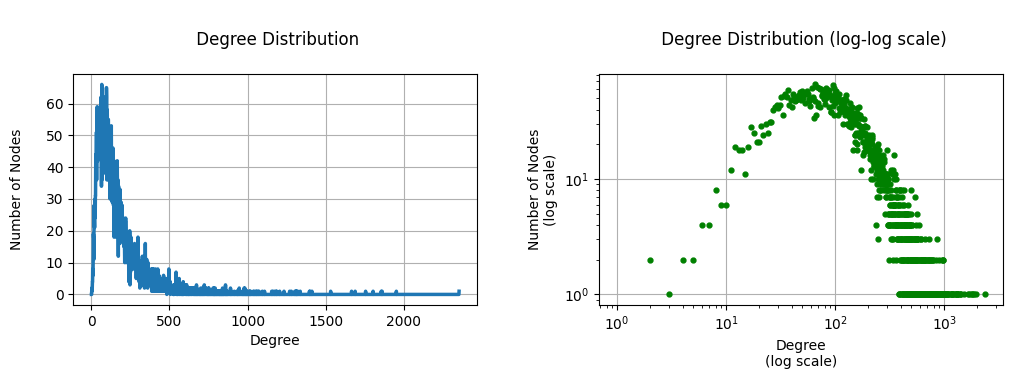

In [7]:
degree_distrib = nx.degree_histogram(G)
nodes = [i for i in range(0, len(degree_distrib))]

degree_distrib = [degree_distrib[i] for i in range(len(degree_distrib))]

visualize_degree_distrib(nodes, degree_distrib)

In [8]:
## For each topic, what are the most cited articles? → Edge analysis

def top_cited_articles(class_id, n):

  this_class = [x for x,y in enumerate(wikivitals.labels) if y == class_id]
  subgraph = G.subgraph(this_class)

  node_edge_counts = {node: subgraph.degree(node) for node in subgraph.nodes()}

  top_nodes = {k: v for k, v in sorted(node_edge_counts.items(), key=lambda item: item[1], reverse=True)}

  top_nodes_names = {wikivitals.names[idx]: count for idx, count in top_nodes.items()}

  return [(k, top_nodes_names[k]) for k in list(top_nodes_names)][:n]

In [9]:
for i in range(10):

  this_label = [key for key in label_id.keys() if label_id[key] == i][0]
  this_top =  [x[0] for x in top_cited_articles(i, 5)]
  this_top = ["'" + s + "'" for s in this_top]

  print(f'{[this_label]} → {", ".join(this_top)}')

['Arts'] → 'Romanticism', 'Modernism', 'Symbolism (arts)', 'Modern art', 'Baroque'
['Biological and health sciences'] → 'Taxonomy (biology)', 'Animal', 'Chordate', 'Plant', 'Mammal'
['Everyday life'] → 'Marriage', 'Olympic Games', 'Softball', 'Rugby sevens', 'Association football'
['Geography'] → 'Geographic coordinate system', 'France', 'Europe', 'United States', 'China'
['History'] → 'Ottoman Empire', 'Roman Empire', 'Byzantine Empire', 'Russian Empire', 'British Empire'
['Mathematics'] → 'Mathematical analysis', 'Real number', 'Geometry', 'Function (mathematics)', 'Mathematics'
['People'] → 'Ralph Waldo Emerson', 'Aristotle', 'Bertrand Russell', 'Jean-Jacques Rousseau', 'Georg Wilhelm Friedrich Hegel'
['Philosophy and religion'] → 'Religion', 'Christianity', 'Taoism', 'Mysticism', 'Pantheism'
['Physical sciences'] → 'Oxygen', 'Hydrogen', 'Earth', 'Chemical element', 'Nitrogen'
['Society and social sciences'] → 'Slavery', 'Law', 'English language', 'Latin', 'European Union'


In [10]:
## WIKIPEDIA RACE

In [11]:
def find_orphan_nodes(adjacency_matrix, graph):

    orphan_nodes = []

    for j in range(adjacency_matrix.shape[0]):

        if np.all(adjacency_matrix[:, j] == 0): orphan_nodes.append(j)

    for node in orphan_nodes:
      if list(graph.predecessors(node)): raise ValueError(f'Node {node} is not orphan!')

    print(f'\n Orphan nodes: {len(orphan_nodes)}\n')

    return orphan_nodes

In [12]:
orphan_nodes = find_orphan_nodes(adj_matrix, G)


 Orphan nodes: 30



In [13]:
def find_dead_ends(adjacency_matrix, graph):

    death_ends = []

    for i in range(adjacency_matrix.shape[0]):

        if np.all(adjacency_matrix[i, :] == 0): death_ends.append(i)

    for node in death_ends:
      if list(graph.successors(node)): raise ValueError(f'Node {node} is not dead end!')

    print(f'\n Dead end nodes: {len(death_ends)}\n')

    return death_ends

In [14]:
death_ends = find_dead_ends(adj_matrix, G)


 Dead end nodes: 2



In [15]:

def dijkstra_shortest_path(graph, source, target):

    distances = {node: float('inf') for node in graph.nodes()}
    distances[source] = 0

    predecessors = {node: None for node in graph.nodes()}

    queue = [source]

    while queue:
        current_node = queue.pop(0)

        if current_node == target:
            path = []
            backtrack_node = current_node
            while backtrack_node is not None:
                path.insert(0, backtrack_node)
                backtrack_node = predecessors[backtrack_node]
            return path


        for neighbor in graph.neighbors(current_node):
            if distances[neighbor] == float('inf'):  # Se non è stato visitato
                distances[neighbor] = distances[current_node] + 1
                predecessors[neighbor] = current_node
                queue.append(neighbor)


    return []


In [16]:
shortest_path = nx.dijkstra_path(G, 0, 111)

shortest_path = dijkstra_shortest_path(G, 0, 111)
shortest_path

[0, 58, 3387, 111]

In [17]:
iterations = 20000

d = {}

if os.path.exists("length_of_paths.pickle"):
  with open("length_of_paths.pickle", 'rb') as f: d = pickle.load(f)

else:
  for i in tqdm(range(iterations)):

    node1, node2 = random.sample(list(G.nodes()), 2)

    # while node1 in death_ends or node2 in orphan_nodes:
      #  node1, node2 = random.sample(list(G.nodes()), 2)

    while (node1, node2) in d:
      node1, node2 = random.sample(list(G.nodes()), 2)

    shortest_path = dijkstra_shortest_path(G, node1, node2 )

    d[(node1, node2)] = shortest_path

  with open('length_of_paths.pickle', 'wb') as f: pickle.dump(d, f)


In [18]:
len([(x,v) for x,v in d.items() if len(v) == 5]), len(d)

(1023, 20000)


{0: 61, 2: 159, 3: 5561, 4: 13185, 5: 1023, 6: 11}



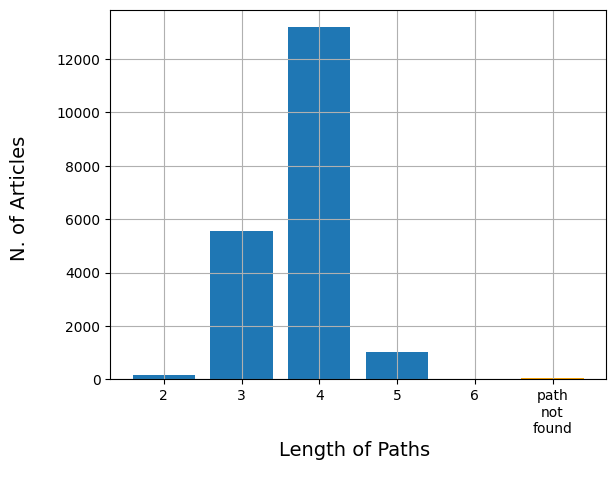

In [19]:
counter = dict(Counter(len(v) for v in d.values()))
sorted_counter = dict(sorted(counter.items()))

print(f'\n{sorted_counter}\n')

show_length_of_paths(sorted_counter)

In [20]:
total_keys = sum(list(sorted_counter.values()))

weighted_sum = sum(length * count for length, count in sorted_counter.items())

weighted_average = round(weighted_sum / total_keys, 2)

print(f"media ponderata {weighted_average}")

media ponderata 3.75


In [44]:
def get_neighbors_at_levels(G, node, max_level=7):

    levels = {0: [node]}
    visited = {node}

    for level in range(1, max_level + 1):
        neighbors = set()
        for n in levels[level - 1]:
            neighbors.update(set(G.successors(n)) - visited)
        if not neighbors:
            break
        levels[level] = list(neighbors)
        visited.update(neighbors)

    return levels


In [188]:
result = get_neighbors_at_levels(G, 2951, max_level=7)

for k,v in result.items():
  print(k, len(v))

0 1
1 679
2 6927
3 2354
4 20


In [88]:
def cum_sum(una_lista):
  cumulative_sums = []
  cumulative_sum = 0
  for lst in una_lista.values():
      cumulative_sum += len(lst)
      cumulative_sums.append(cumulative_sum)

  return cumulative_sums

In [262]:

indexes= [2951, 7108, 8319, 5365, 2526]

data = {wikivitals.names[indexes[i]]:[] for i in  range(len(indexes))}

for i in range(len(indexes)):

  result = get_neighbors_at_levels(G, indexes[i], max_level=8)
  result = cum_sum(result)
  data[wikivitals.names[indexes[i]]] = result



In [263]:
data

{'Europe': [1, 680, 7607, 9961, 9981],
 'Plato': [1, 395, 6025, 9936, 9981],
 'Snow': [1, 162, 5206, 9926, 9980, 9981],
 'Liquor': [1, 48, 2852, 9743, 9978, 9981],
 'Dream': [1, 96, 4115, 9860, 9980, 9981]}

In [268]:
def do_a_plot(data, total_nodes):

  table_data = []

  for key, value_list in data.items():

    percentages = [str((round((size / total_nodes) * 100, 2)))+" %" for size in value_list]
    table_data.append([key] + percentages)

    plt.plot(range(len(value_list)), value_list, alpha = 0.65, label=key)

  headers = ["Node"] + [f"Hop {i+1}" for i in range(len(result))]
  this_table = tabulate(table_data, headers=headers, tablefmt="pretty")

  plt.gca().spines['right'].set_color('none')
  plt.gca().spines['top'].set_color('none')

  plt.title("\n\n")
  plt.xlabel("\n Degrees of Separation \n", fontsize=14)
  plt.ylabel("N. of Articles \n", fontsize= 14)


  plt.grid()
  plt.legend(loc ="lower right", prop={'size': 9})
  plt.show()

  return data, this_table


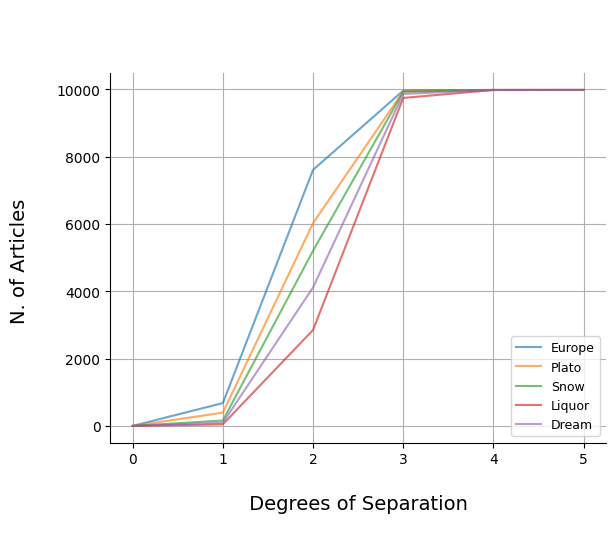

In [265]:
table  = do_a_plot(data, 10000)

In [266]:
print(table)

+--------+--------+--------+---------+---------+---------+--------+
|  Node  | Hop 1  | Hop 2  |  Hop 3  |  Hop 4  |  Hop 5  | Hop 6  |
+--------+--------+--------+---------+---------+---------+--------+
| Europe | 0.01 % | 6.79 % | 75.99 % | 99.5 %  | 99.7 %  |        |
| Plato  | 0.01 % | 3.95 % | 60.18 % | 99.25 % | 99.7 %  |        |
|  Snow  | 0.01 % | 1.62 % | 52.0 %  | 99.15 % | 99.69 % | 99.7 % |
| Liquor | 0.01 % | 0.48 % | 28.49 % | 97.32 % | 99.67 % | 99.7 % |
| Dream  | 0.01 % | 0.96 % | 41.1 %  | 98.49 % | 99.69 % | 99.7 % |
+--------+--------+--------+---------+---------+---------+--------+
